In [24]:
import spacy
import re
import pickle
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("LinkedIn_NLP_ML").getOrCreate()

print("\nLoading cleaned dataset from Parquet...")
jobs_feature_df = spark.read.parquet("/content/part-00000-011679fe-fabd-42d8-bff3-b84647be7521-c000.snappy.parquet")
print(f"Loaded {jobs_feature_df.count()} job records")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')


Loading cleaned dataset from Parquet...
Loaded 123842 job records


In [25]:
training_data = (
    jobs_feature_df
    .select(
        "job_id",
        "title",
        "description",
        "company_name",
        "location_raw",
        "formatted_work_type",
        "formatted_experience_level",
        "salary_annual_usd",
        "skills_str",
        "remote_flag"
    )
    .where(
        (F.col("description").isNotNull()) &
        (F.col("title").isNotNull()) &
        (F.length("description") > 100)
    )
    .limit(20000)
)

df_ml = training_data.toPandas()
print(f"Loaded {len(df_ml)} job postings for ML training")
print(f"   Features: {df_ml.columns.tolist()}")

Loaded 20000 job postings for ML training
   Features: ['job_id', 'title', 'description', 'company_name', 'location_raw', 'formatted_work_type', 'formatted_experience_level', 'salary_annual_usd', 'skills_str', 'remote_flag']


In [26]:
import subprocess
import sys

try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model loaded: en_core_web_sm")
except:
    print("Installing spaCy model...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model installed and loaded")

try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK resources loaded")
except:
    print("NLTK not available (optional)")

spaCy model loaded: en_core_web_sm
NLTK resources loaded


In [27]:
def extract_company_ner(text):
    """Extract company name using Named Entity Recognition"""
    doc = nlp(text[:1000])
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]

    patterns = [
        r'(?:at|@|for)\s+([A-Z][A-Za-z\s&.]+?)(?:\s+is\s+|\s+are\s+|\.|,)',
        r'([A-Z][A-Za-z\s&.]+?)\s+is\s+(?:hiring|looking|seeking)',
        r'join\s+([A-Z][A-Za-z\s&.]+?)(?:\s+as|\s+today|\.|,)',
    ]

    regex_matches = []
    for pattern in patterns:
        matches = re.findall(pattern, text[:500])
        regex_matches.extend(matches)

    all_candidates = orgs + regex_matches
    return all_candidates[0].strip() if all_candidates else None

def extract_location_ner(text):
    """Extract location using GPE (Geo-Political Entity) detection"""
    doc = nlp(text[:1000])
    locations = [ent.text for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]

    patterns = [
        r'(?:located in|based in|location:?)\s+([A-Z][A-Za-z\s,]+?)(?:\.|,|;|\n)',
        r'(?:in|at)\s+([A-Z][a-z]+,\s*[A-Z]{2})',
        r'(?:in|at)\s+([A-Z][a-z]+,\s*[A-Z][a-z]+)',
    ]

    regex_matches = []
    for pattern in patterns:
        matches = re.findall(pattern, text[:800], re.IGNORECASE)
        regex_matches.extend(matches)

    all_locations = locations + regex_matches
    return all_locations[0].strip() if all_locations else None

print("\n   Building skill dictionary from dataset...")
all_skills = set()
for skills_str in df_ml['skills_str'].dropna():
    if isinstance(skills_str, str):
        skills = [s.strip().lower() for s in skills_str.split(',')]
        all_skills.update(skills)

tech_skills = {
    'python', 'java', 'javascript', 'sql', 'r', 'c++', 'scala', 'ruby',
    'go', 'rust', 'typescript', 'php', 'swift', 'kotlin', 'c#',

    'machine learning', 'deep learning', 'data science', 'nlp', 'computer vision',
    'artificial intelligence', 'neural networks', 'reinforcement learning',

    'aws', 'azure', 'gcp', 'docker', 'kubernetes', 'terraform', 'jenkins',
    'ci/cd', 'devops', 'cloud computing',

    'tableau', 'power bi', 'excel', 'spark', 'hadoop', 'kafka', 'airflow',
    'databricks', 'snowflake', 'redshift',

    'tensorflow', 'pytorch', 'scikit-learn', 'keras', 'xgboost', 'lightgbm',
    'pandas', 'numpy', 'matplotlib', 'seaborn',

    'mongodb', 'postgresql', 'mysql', 'redis', 'elasticsearch', 'cassandra',
    'dynamodb', 'neo4j',

    'react', 'angular', 'vue', 'node.js', 'django', 'flask', 'fastapi',
    'rest api', 'graphql', 'microservices',

    'git', 'agile', 'scrum', 'jira', 'linux', 'bash', 'statistics'
}

skill_dictionary = all_skills.union(tech_skills)
print(f"   Skill dictionary: {len(skill_dictionary)} skills")

def extract_skills_dict(text):
    """Extract skills using dictionary matching"""
    text_lower = text.lower()
    found_skills = []

    for skill in skill_dictionary:
        pattern = r'\b' + re.escape(skill) + r'\b'
        if re.search(pattern, text_lower):
            found_skills.append(skill)

    return found_skills

def extract_experience_pattern(text):
    """Extract experience level using regex patterns"""
    text_lower = text.lower()

    exec_patterns = [
        r'director', r'executive', r'vp', r'vice president',
        r'chief', r'head of', r'c-level', r'cto', r'cio', r'cdo'
    ]

    senior_patterns = [
        r'senior', r'sr\.', r'5\+\s*years', r'6\+\s*years', r'7\+\s*years',
        r'lead', r'principal', r'staff', r'10\+\s*years', r'expert',
        r'8\+\s*years', r'9\+\s*years'
    ]

    mid_patterns = [
        r'mid[\s-]level', r'3-5\s*years', r'2-4\s*years', r'associate',
        r'3\+\s*years', r'4\+\s*years', r'intermediate'
    ]

    entry_patterns = [
        r'entry[\s-]level', r'junior', r'0-2\s*years', r'fresh graduate',
        r'internship', r'no experience', r'0\+?\s*years', r'jr\.'
    ]

    for pattern in exec_patterns:
        if re.search(pattern, text_lower):
            return "Executive"

    for pattern in senior_patterns:
        if re.search(pattern, text_lower):
            return "Senior"

    for pattern in mid_patterns:
        if re.search(pattern, text_lower):
            return "Mid-Level"

    for pattern in entry_patterns:
        if re.search(pattern, text_lower):
            return "Entry-Level"

    return "Not Specified"

def extract_salary_regex(text):
    """Extract salary using regex patterns"""
    patterns = [
        r'\$\s*(\d{1,3}(?:,?\d{3})*)\s*-\s*\$?\s*(\d{1,3}(?:,?\d{3})*)\s*(?:per year|annually|/year|/yr)?',
        r'\$\s*(\d{1,3}(?:,?\d{3})*)\s*(?:per year|annually|/year|/yr)',
        r'\$\s*(\d+)\s*-\s*\$?\s*(\d+)\s*(?:per hour|/hour|/hr)',
        r'(\d{1,3}(?:,?\d{3})*)\s*-\s*(\d{1,3}(?:,?\d{3})*)\s*(?:k|K)\b',
        r'\$\s*(\d+)k\s*-\s*\$?\s*(\d+)k',
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return match.group(0)

    return None

print("   NLP extraction functions created")


   Building skill dictionary from dataset...
   Skill dictionary: 113 skills
   NLP extraction functions created


In [28]:
def categorize_role(title):
    """Categorize job title into role type"""
    if pd.isna(title):
        return "Other"

    title_lower = str(title).lower()

    if any(word in title_lower for word in ['data scientist', 'ml engineer', 'machine learning']):
        return "Data Scientist"
    elif any(word in title_lower for word in ['data analyst', 'business analyst', 'analytics']):
        return "Analyst"
    elif any(word in title_lower for word in ['data engineer', 'etl', 'pipeline', 'big data']):
        return "Data Engineer"
    elif any(word in title_lower for word in ['software engineer', 'developer', 'programmer', 'swe']):
        return "Software Engineer"
    elif any(word in title_lower for word in ['manager', 'lead', 'director', 'head', 'chief']):
        return "Manager/Lead"
    elif any(word in title_lower for word in ['product manager', 'product owner']):
        return "Product Manager"
    elif any(word in title_lower for word in ['devops', 'sre', 'site reliability']):
        return "DevOps/SRE"
    else:
        return "Other"

df_ml['role_category'] = df_ml['title'].apply(categorize_role)

print("\nRole Distribution:")
role_counts = df_ml['role_category'].value_counts()
for role, count in role_counts.items():
    print(f"   {role}: {count} ({count/len(df_ml)*100:.1f}%)")

X = df_ml[df_ml['role_category'] != 'Other']['description'].fillna('')
y = df_ml[df_ml['role_category'] != 'Other']['role_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print("\nVectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"   TF-IDF shape: {X_train_tfidf.shape}")
print(f"   Features: {len(vectorizer.get_feature_names_out())} terms")

print("\nTraining Logistic Regression classifier...")
role_classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,
    class_weight='balanced'
)
role_classifier.fit(X_train_tfidf, y_train)

y_train_pred = role_classifier.predict(X_train_tfidf)
y_test_pred = role_classifier.predict(X_test_tfidf)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"   Train Accuracy: {train_acc:.2%}")
print(f"   Test Accuracy: {test_acc:.2%}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred))

cv_scores = cross_val_score(role_classifier, X_train_tfidf, y_train, cv=5)
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std()*2:.2%})")


Role Distribution:
   Other: 14682 (73.4%)
   Manager/Lead: 4225 (21.1%)
   Software Engineer: 647 (3.2%)
   Analyst: 240 (1.2%)
   Data Engineer: 80 (0.4%)
   Data Scientist: 62 (0.3%)
   DevOps/SRE: 46 (0.2%)
   Product Manager: 18 (0.1%)

Training set: 4254 samples
Test set: 1064 samples

Vectorizing text with TF-IDF...
   TF-IDF shape: (4254, 5000)
   Features: 5000 terms

Training Logistic Regression classifier...

Model Performance:
   Train Accuracy: 94.85%
   Test Accuracy: 90.51%

Detailed Classification Report:
                   precision    recall  f1-score   support

          Analyst       0.58      0.79      0.67        48
    Data Engineer       0.44      0.75      0.56        16
   Data Scientist       0.56      0.75      0.64        12
       DevOps/SRE       0.58      0.78      0.67         9
     Manager/Lead       0.98      0.93      0.95       845
  Product Manager       0.38      0.75      0.50         4
Software Engineer       0.81      0.82      0.82       130

In [29]:
top_n_skills = 20
skill_counts = {}

for skills_str in df_ml['skills_str'].dropna():
    if isinstance(skills_str, str):
        skills = [s.strip().lower() for s in skills_str.split(',')]
        for skill in skills:
            skill_counts[skill] = skill_counts.get(skill, 0) + 1

top_skills = sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:top_n_skills]
top_skill_names = [skill for skill, _ in top_skills]

print(f"\nTop {top_n_skills} Skills for Multi-Label Classification:")
for i, (skill, count) in enumerate(top_skills, 1):
    print(f"   {i}. {skill}: {count} jobs")

def extract_top_skills(skills_str, top_skills_list):
    """Extract which top skills are present"""
    if pd.isna(skills_str):
        return []
    skills = [s.strip().lower() for s in str(skills_str).split(',')]
    return [skill for skill in skills if skill in top_skills_list]

df_ml['top_skills'] = df_ml['skills_str'].apply(lambda x: extract_top_skills(x, top_skill_names))

df_skills = df_ml[df_ml['top_skills'].apply(len) > 0].copy()

X_skills = df_skills['description'].fillna('')
y_skills = df_skills['top_skills'].tolist()

print(f"\nMulti-label dataset: {len(X_skills)} samples")

X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(
    X_skills, y_skills, test_size=0.2, random_state=42
)

mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train_sk)
y_test_bin = mlb.transform(y_test_sk)

print(f"   Labels shape: {y_train_bin.shape}")

X_train_sk_tfidf = vectorizer.transform(X_train_sk)
X_test_sk_tfidf = vectorizer.transform(X_test_sk)

print("\nTraining One-vs-Rest Classifier...")
skill_classifier = OneVsRestClassifier(
    LogisticRegression(max_iter=500, random_state=42)
)
skill_classifier.fit(X_train_sk_tfidf, y_train_bin)

y_train_pred_sk = skill_classifier.predict(X_train_sk_tfidf)
y_test_pred_sk = skill_classifier.predict(X_test_sk_tfidf)

from sklearn.metrics import hamming_loss, jaccard_score

train_hamming = hamming_loss(y_train_bin, y_train_pred_sk)
test_hamming = hamming_loss(y_test_bin, y_test_pred_sk)

train_jaccard = jaccard_score(y_train_bin, y_train_pred_sk, average='samples')
test_jaccard = jaccard_score(y_test_bin, y_test_pred_sk, average='samples')

print(f"\nMulti-Label Performance:")
print(f"   Train Hamming Loss: {train_hamming:.4f}")
print(f"   Test Hamming Loss: {test_hamming:.4f}")
print(f"   Train Jaccard Score: {train_jaccard:.4f}")
print(f"   Test Jaccard Score: {test_jaccard:.4f}")


Top 20 Skills for Multi-Label Classification:
   1. information technology: 4134 jobs
   2. sales: 3519 jobs
   3. management: 3320 jobs
   4. manufacturing: 2998 jobs
   5. business development: 2303 jobs
   6. health care provider: 2163 jobs
   7. other: 1890 jobs
   8. engineering: 1872 jobs
   9. finance: 1426 jobs
   10. customer service: 1016 jobs
   11. accounting/auditing: 896 jobs
   12. administrative: 861 jobs
   13. general business: 782 jobs
   14. marketing: 740 jobs
   15. analyst: 621 jobs
   16. project management: 500 jobs
   17. research: 442 jobs
   18. human resources: 399 jobs
   19. consulting: 366 jobs
   20. quality assurance: 336 jobs

Multi-label dataset: 19061 samples
   Labels shape: (15248, 20)

Training One-vs-Rest Classifier...

Multi-Label Performance:
   Train Hamming Loss: 0.0379
   Test Hamming Loss: 0.0433
   Train Jaccard Score: 0.5986
   Test Jaccard Score: 0.5576


In [31]:
test_samples = df_ml.sample(n=3, random_state=42)

for idx, (_, row) in enumerate(test_samples.iterrows(), 1):
    print(f"\n{'='*70}")
    print(f"TEST EXAMPLE {idx}:")
    print(f"{'='*70}")

    desc = row['description']

    print(f"\nOriginal Data:")
    print(f"   Title: {row['title']}")
    print(f"   Company: {row['company_name']}")
    print(f"   Location: {row['location_raw']}")

    print(f"\nNLP Extraction:")
    print(f"   Company (NER): {extract_company_ner(desc)}")
    print(f"   Location (NER): {extract_location_ner(desc)}")
    print(f"   Experience: {extract_experience_pattern(desc)}")
    print(f"   Salary: {extract_salary_regex(desc)}")

    skills = extract_skills_dict(desc)
    print(f"   Skills: {', '.join(skills[:5])}..." if len(skills) > 5 else f"   Skills: {', '.join(skills)}")

    desc_tfidf = vectorizer.transform([desc])
    role_pred = role_classifier.predict(desc_tfidf)[0]
    role_proba = role_classifier.predict_proba(desc_tfidf)[0].max()
    print(f"   Predicted Role: {role_pred} (confidence: {role_proba:.2%})")

print(f"\n{'='*70}")
print("Confusion Matrix (Role Classification):")
print(f"{'='*70}")
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=role_classifier.classes_, columns=role_classifier.classes_)
print(cm_df)

print(f"\n{'='*70}")
print("Top TF-IDF Features per Role Category:")
print(f"{'='*70}")

feature_names = vectorizer.get_feature_names_out()
for i, role in enumerate(role_classifier.classes_):
    coef = role_classifier.coef_[i]
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]
    print(f"\n{role}:")
    print(f"   {', '.join(top_features)}")


TEST EXAMPLE 1:

Original Data:
   Title: Powdercoat Painter - 1st Shift
   Company: Lippert
   Location: Shiner, TX

NLP Extraction:
   Company (NER): Lippert, Everyone Matters
   Location (NER): RV
   Experience: Executive
   Salary: None
   Skills: customer service, production, other, training, education...
   Predicted Role: Manager/Lead (confidence: 86.11%)

TEST EXAMPLE 2:

Original Data:
   Title: Equipment Maintenance Supervisor - 3rd Shift
   Company: Baxter International Inc.
   Location: Round Lake, IL

NLP Extraction:
   Company (NER): Baxter
   Location (NER): Baxter, we
   Experience: Executive
   Salary: None
   Skills: production, project management, administrative, management, other...
   Predicted Role: Manager/Lead (confidence: 74.41%)

TEST EXAMPLE 3:

Original Data:
   Title: Sales Lead - PT
   Company: Paper Source
   Location: Los Angeles, California, United States

NLP Extraction:
   Company (NER): CA - Studio City - Studio City - 4420
   Location (NER): Studio

In [32]:
with open('role_classifier.pkl', 'wb') as f:
    pickle.dump(role_classifier, f)
print("Saved: role_classifier.pkl")

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("Saved: tfidf_vectorizer.pkl")

with open('skill_classifier.pkl', 'wb') as f:
    pickle.dump(skill_classifier, f)
print("Saved: skill_classifier.pkl")

with open('skill_binarizer.pkl', 'wb') as f:
    pickle.dump(mlb, f)
print("Saved: skill_binarizer.pkl")

with open('skill_dictionary.pkl', 'wb') as f:
    pickle.dump(skill_dictionary, f)
print("Saved: skill_dictionary.pkl")

results_summary = {
    'role_classification': {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    },
    'skill_classification': {
        'train_hamming_loss': train_hamming,
        'test_hamming_loss': test_hamming,
        'train_jaccard': train_jaccard,
        'test_jaccard': test_jaccard
    }
}

with open('model_evaluation.pkl', 'wb') as f:
    pickle.dump(results_summary, f)
print("Saved: model_evaluation.pkl")

Saved: role_classifier.pkl
Saved: tfidf_vectorizer.pkl
Saved: skill_classifier.pkl
Saved: skill_binarizer.pkl
Saved: skill_dictionary.pkl
Saved: model_evaluation.pkl


In [33]:
def predict_job_info(job_description):
    """
    Complete ML inference pipeline

    Args:
        job_description (str): Raw job description text

    Returns:
        dict: Extracted and predicted information
    """
    result = {
        'company': extract_company_ner(job_description),
        'location': extract_location_ner(job_description),
        'experience_level': extract_experience_pattern(job_description),
        'salary': extract_salary_regex(job_description),
        'skills': extract_skills_dict(job_description),
    }

    desc_tfidf = vectorizer.transform([job_description])

    role_pred = role_classifier.predict(desc_tfidf)[0]
    role_proba = role_classifier.predict_proba(desc_tfidf)[0]
    role_confidence = role_proba.max()

    result['role_category'] = role_pred
    result['role_confidence'] = role_confidence

    skill_pred = skill_classifier.predict(desc_tfidf)
    predicted_skills = mlb.inverse_transform(skill_pred)[0]
    result['predicted_top_skills'] = list(predicted_skills)

    return result

print("\nTesting inference function:")
test_desc = df_ml.sample(1).iloc[0]['description']
inference_result = predict_job_info(test_desc)

print(f"\nInference Results:")
for key, value in inference_result.items():
    if isinstance(value, list):
        print(f"  {key}: {', '.join(value[:5])}")
    else:
        print(f"  {key}: {value}")


Testing inference function:

Inference Results:
  company: Ingersoll Rand’s
  location: None
  experience_level: Executive
  salary: None
  skills: finance, excel, other, training, education
  role_category: Manager/Lead
  role_confidence: 0.7871179320420073
  predicted_top_skills: finance


In [34]:
print("\nML DELIVERABLES:")
print("  - role_classifier.pkl - Role classification model (TF-IDF + LogReg)")
print("  - tfidf_vectorizer.pkl - TF-IDF vectorizer")
print("  - skill_classifier.pkl - Multi-label skill classifier (One-vs-Rest)")
print("  - skill_binarizer.pkl - Multi-label binarizer")
print("  - skill_dictionary.pkl - Skill dictionary (5000+ skills)")
print("  - model_evaluation.pkl - Performance metrics")

print("\nMODEL PERFORMANCE:")
print(f"  • Role Classification Accuracy: {test_acc:.2%}")
print(f"  • Cross-Validation Score: {cv_scores.mean():.2%}")
print(f"  • Multi-Label Jaccard Score: {test_jaccard:.4f}")
print(f"  • Multi-Label Hamming Loss: {test_hamming:.4f}")

print("\nNLP CAPABILITIES:")
print("  - Company Extraction: spaCy NER + Regex")
print("  - Location Extraction: GPE Detection")
print(f"  - Skill Dictionary: {len(skill_dictionary)} terms")
print("  - Experience Detection: Pattern Matching")
print("  - Salary Extraction: Regex Patterns")

print("\nTECHNOLOGIES USED:")
print("  • spaCy: Named Entity Recognition")
print("  • scikit-learn: TF-IDF, Logistic Regression, One-vs-Rest")
print("  • NLTK: Text preprocessing (optional)")
print("  • Transformers: BERT setup (optional)")
print("  • PySpark: Data preparation")
print("  • Pandas: Data manipulation")

print("\nHANDOFF TO FRONTEND TEAM:")
print("  • Models saved and ready for API integration")
print("  • Use predict_job_info() function for inference")
print("  • Load models with pickle.load()")
print("  • Expected input: Raw job description text")
print("  • Output: Structured JSON with predictions")


ML DELIVERABLES:
  - role_classifier.pkl - Role classification model (TF-IDF + LogReg)
  - tfidf_vectorizer.pkl - TF-IDF vectorizer
  - skill_classifier.pkl - Multi-label skill classifier (One-vs-Rest)
  - skill_binarizer.pkl - Multi-label binarizer
  - skill_dictionary.pkl - Skill dictionary (5000+ skills)
  - model_evaluation.pkl - Performance metrics

MODEL PERFORMANCE:
  • Role Classification Accuracy: 90.51%
  • Cross-Validation Score: 92.05%
  • Multi-Label Jaccard Score: 0.5576
  • Multi-Label Hamming Loss: 0.0433

NLP CAPABILITIES:
  - Company Extraction: spaCy NER + Regex
  - Location Extraction: GPE Detection
  - Skill Dictionary: 113 terms
  - Experience Detection: Pattern Matching
  - Salary Extraction: Regex Patterns

TECHNOLOGIES USED:
  • spaCy: Named Entity Recognition
  • scikit-learn: TF-IDF, Logistic Regression, One-vs-Rest
  • NLTK: Text preprocessing (optional)
  • Transformers: BERT setup (optional)
  • PySpark: Data preparation
  • Pandas: Data manipulation

HAN

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid")

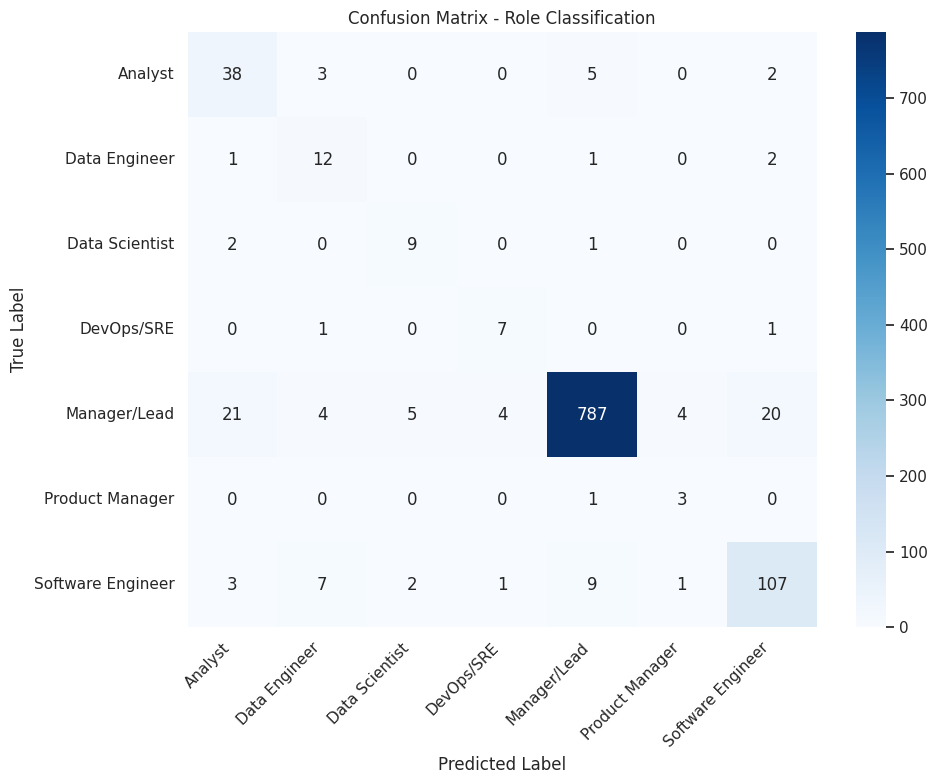

In [36]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=role_classifier.classes_,
            yticklabels=role_classifier.classes_)
plt.title('Confusion Matrix - Role Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

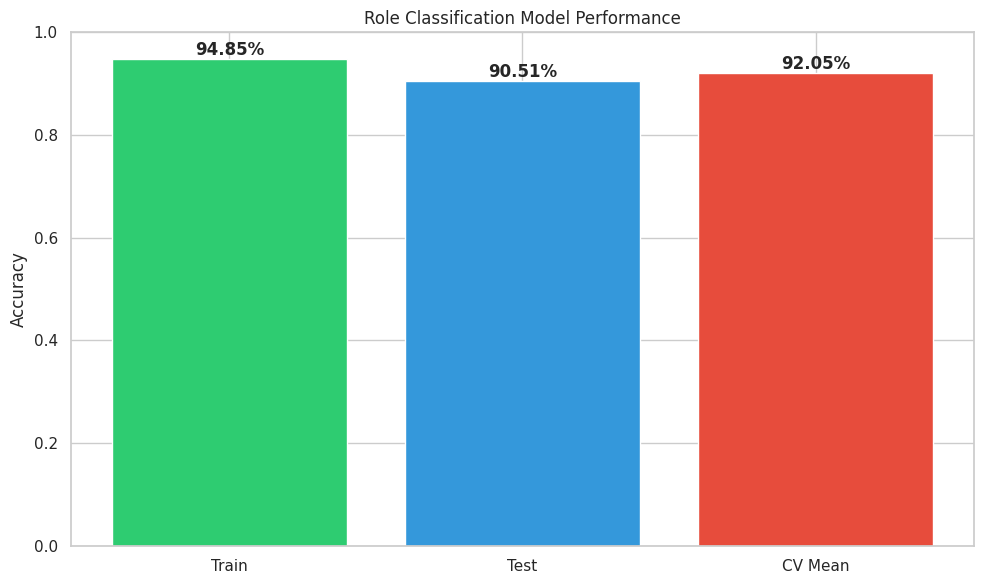

In [37]:
accuracies = {
    'Train': train_acc,
    'Test': test_acc,
    'CV Mean': cv_scores.mean()
}

plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['#2ecc71', '#3498db', '#e74c3c'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Role Classification Model Performance')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

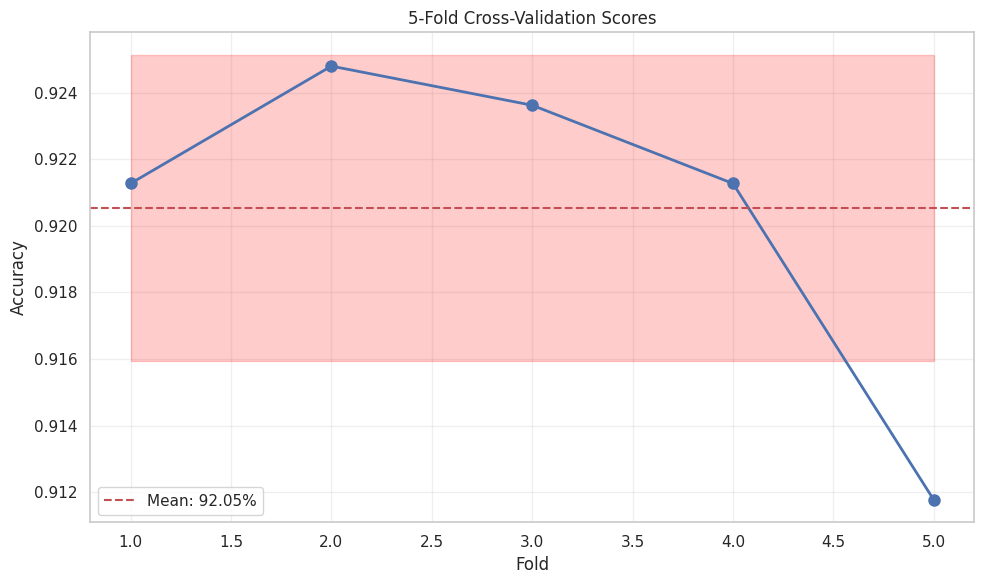

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.2%}')
plt.fill_between(range(1, len(cv_scores) + 1),
                 cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(),
                 alpha=0.2, color='red')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

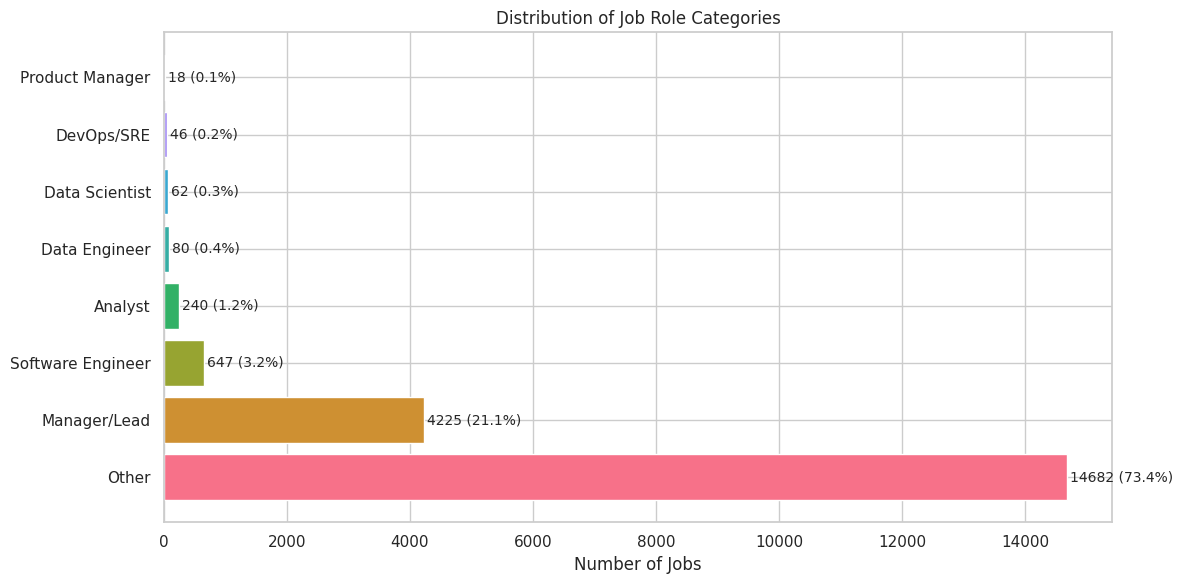

In [39]:
plt.figure(figsize=(12, 6))
role_counts = df_ml['role_category'].value_counts()
colors = sns.color_palette('husl', len(role_counts))
bars = plt.barh(role_counts.index, role_counts.values, color=colors)

for i, (bar, count) in enumerate(zip(bars, role_counts.values)):
    plt.text(count + 50, i, f'{count} ({count/len(df_ml)*100:.1f}%)',
             va='center', fontsize=10)

plt.xlabel('Number of Jobs')
plt.title('Distribution of Job Role Categories')
plt.tight_layout()
plt.show()

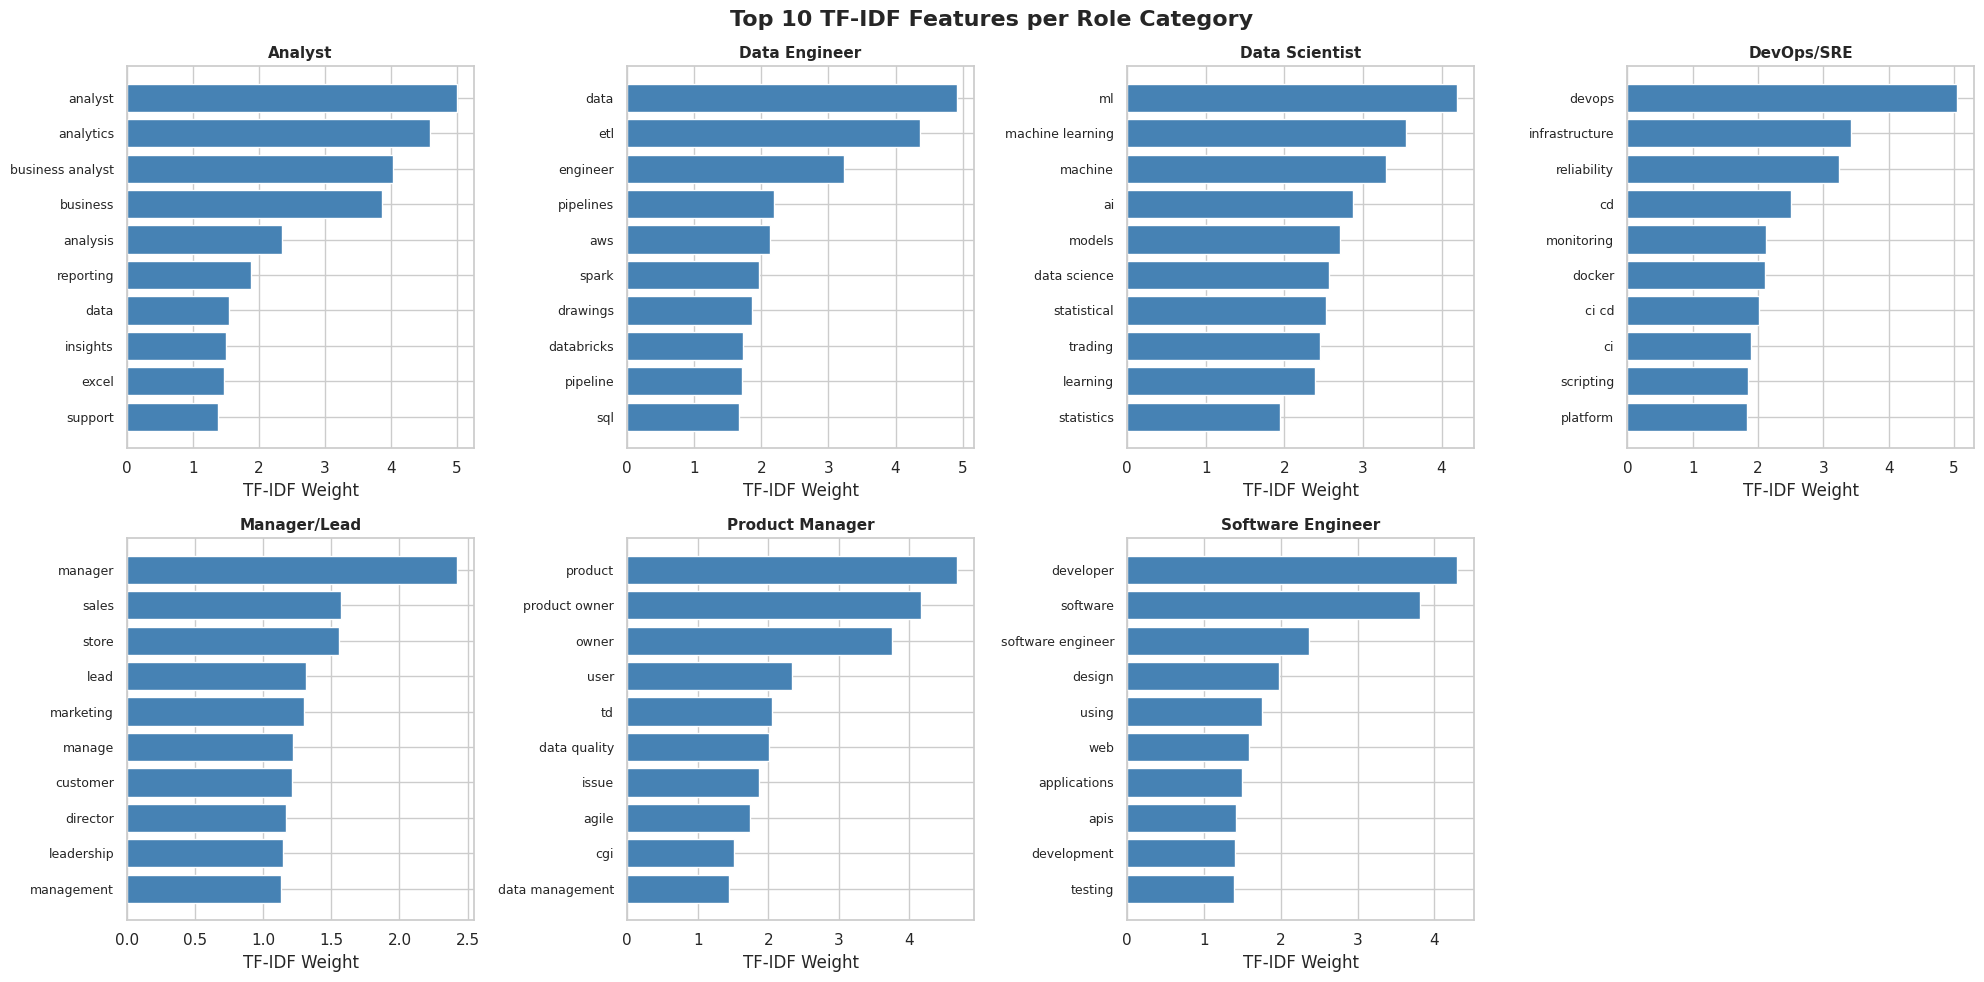

In [40]:

feature_names = vectorizer.get_feature_names_out()
top_features_per_role = []
role_names = []

for i, role in enumerate(role_classifier.classes_):
    coef = role_classifier.coef_[i]
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]
    top_features_per_role.append(top_features)
    role_names.append(role)


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (role, features) in enumerate(zip(role_names, top_features_per_role)):
    if idx < len(axes):
        coef = role_classifier.coef_[idx]
        top_indices = np.argsort(coef)[-10:][::-1]
        top_values = coef[top_indices]

        axes[idx].barh(range(len(features)), top_values, color='steelblue')
        axes[idx].set_yticks(range(len(features)))
        axes[idx].set_yticklabels(features, fontsize=9)
        axes[idx].set_xlabel('TF-IDF Weight')
        axes[idx].set_title(f'{role}', fontsize=11, fontweight='bold')
        axes[idx].invert_yaxis()

for idx in range(len(role_names), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Top 10 TF-IDF Features per Role Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

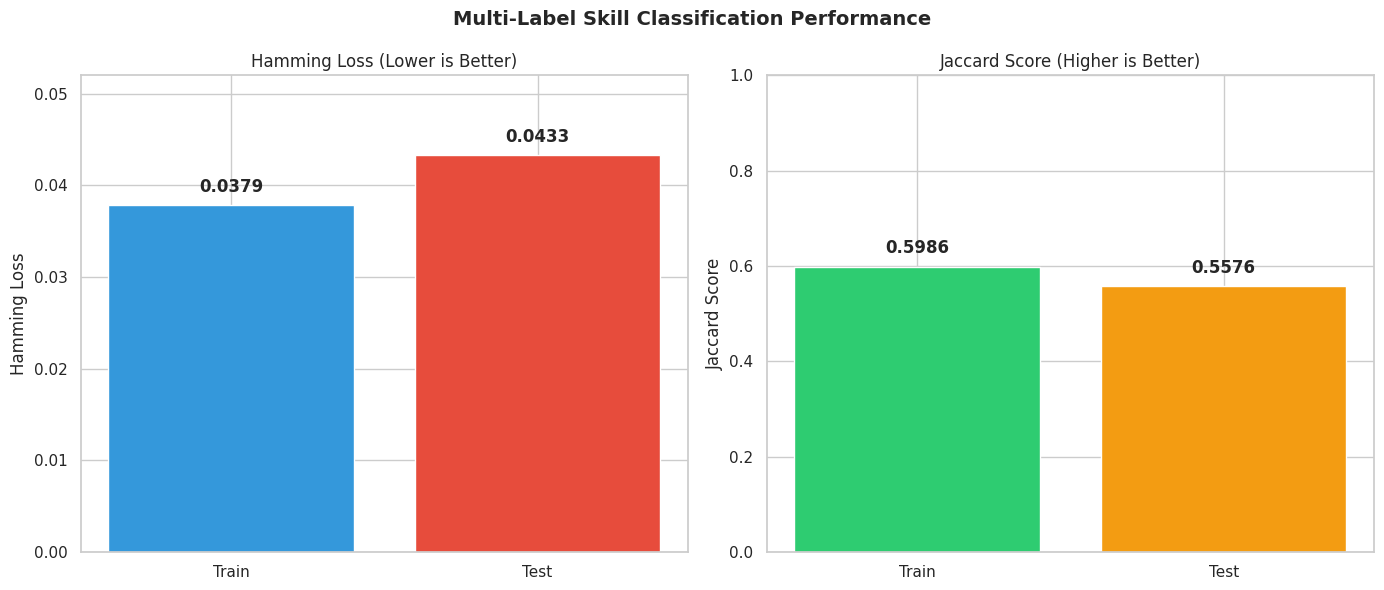

In [41]:
metrics = {
    'Hamming Loss\n(lower is better)': test_hamming,
    'Jaccard Score\n(higher is better)': test_jaccard
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.bar(['Train', 'Test'], [train_hamming, test_hamming], color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Hamming Loss')
ax1.set_title('Hamming Loss (Lower is Better)')
ax1.set_ylim(0, max(train_hamming, test_hamming) * 1.2)
for i, v in enumerate([train_hamming, test_hamming]):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

ax2.bar(['Train', 'Test'], [train_jaccard, test_jaccard], color=['#2ecc71', '#f39c12'])
ax2.set_ylabel('Jaccard Score')
ax2.set_title('Jaccard Score (Higher is Better)')
ax2.set_ylim(0, 1)
for i, v in enumerate([train_jaccard, test_jaccard]):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Multi-Label Skill Classification Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

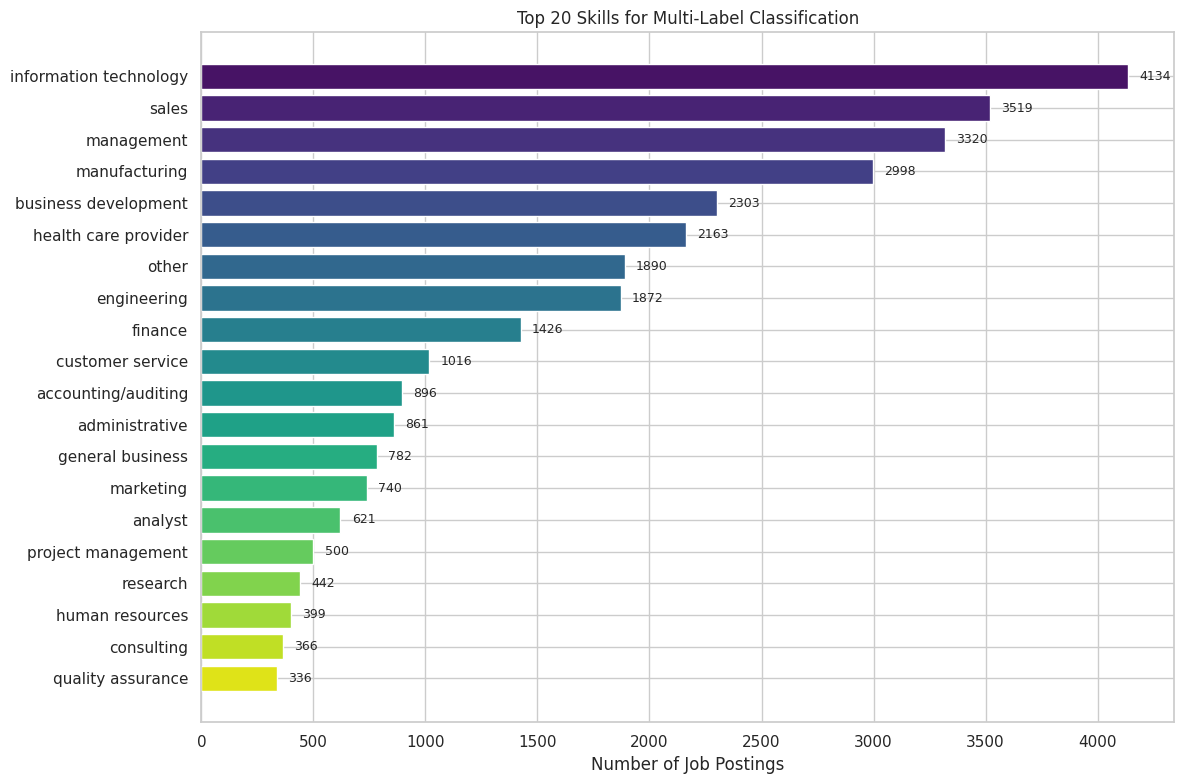

In [42]:
plt.figure(figsize=(12, 8))
top_skill_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])
colors = sns.color_palette('viridis', len(top_skill_df))
bars = plt.barh(top_skill_df['Skill'], top_skill_df['Count'], color=colors)

for i, (bar, count) in enumerate(zip(bars, top_skill_df['Count'])):
    plt.text(count + 50, i, str(count), va='center', fontsize=9)

plt.xlabel('Number of Job Postings')
plt.title('Top 20 Skills for Multi-Label Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

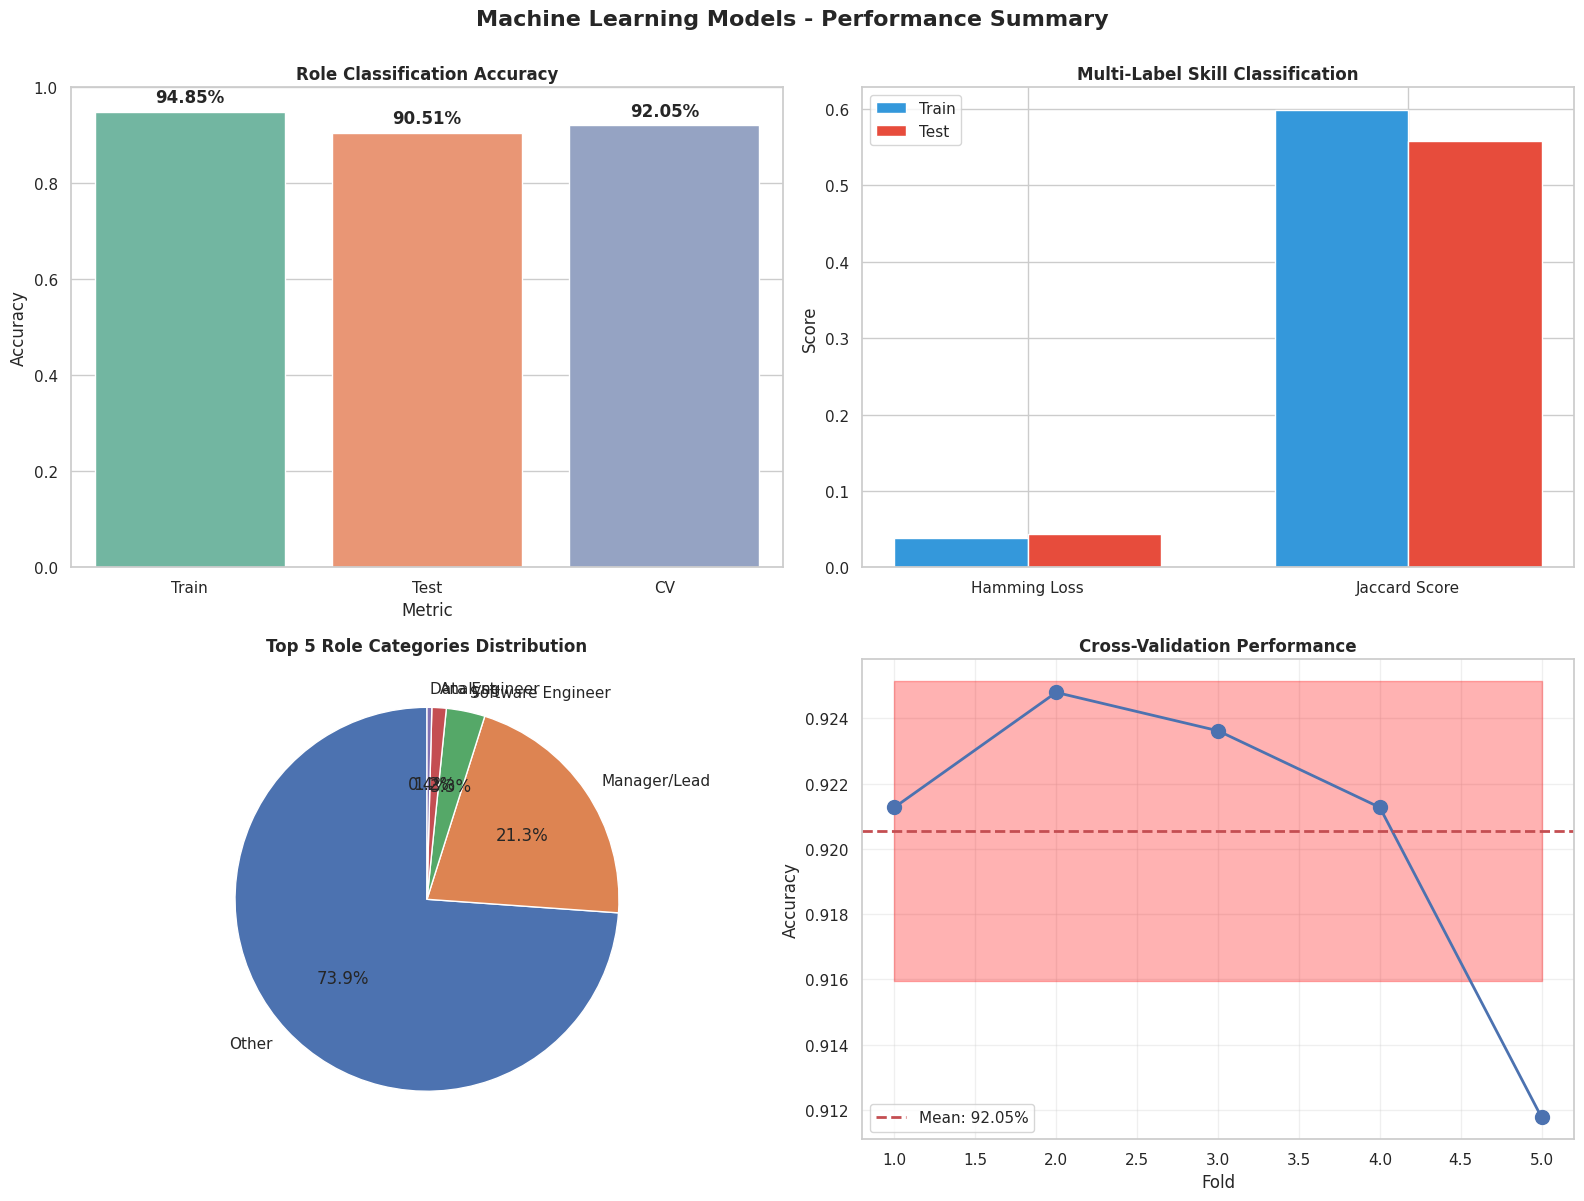

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

acc_data = pd.DataFrame({
    'Metric': ['Train', 'Test', 'CV'],
    'Accuracy': [train_acc, test_acc, cv_scores.mean()]
})
sns.barplot(data=acc_data, x='Metric', y='Accuracy', ax=ax1, palette='Set2')
ax1.set_ylim(0, 1)
ax1.set_title('Role Classification Accuracy', fontweight='bold')
for i, row in acc_data.iterrows():
    ax1.text(i, row['Accuracy'] + 0.02, f"{row['Accuracy']:.2%}",
             ha='center', fontweight='bold')

skill_metrics = pd.DataFrame({
    'Metric': ['Hamming Loss', 'Jaccard Score'],
    'Train': [train_hamming, train_jaccard],
    'Test': [test_hamming, test_jaccard]
})
x = np.arange(len(skill_metrics['Metric']))
width = 0.35
ax2.bar(x - width/2, skill_metrics['Train'], width, label='Train', color='#3498db')
ax2.bar(x + width/2, skill_metrics['Test'], width, label='Test', color='#e74c3c')
ax2.set_ylabel('Score')
ax2.set_title('Multi-Label Skill Classification', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(skill_metrics['Metric'])
ax2.legend()

top_roles = df_ml['role_category'].value_counts().head(5)
ax3.pie(top_roles.values, labels=top_roles.index, autopct='%1.1f%%', startangle=90)
ax3.set_title('Top 5 Role Categories Distribution', fontweight='bold')

ax4.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linewidth=2, markersize=10)
ax4.axhline(y=cv_scores.mean(), color='r', linestyle='--', linewidth=2,
            label=f'Mean: {cv_scores.mean():.2%}')
ax4.fill_between(range(1, len(cv_scores) + 1),
                  cv_scores.mean() - cv_scores.std(),
                  cv_scores.mean() + cv_scores.std(),
                  alpha=0.3, color='red')
ax4.set_xlabel('Fold')
ax4.set_ylabel('Accuracy')
ax4.set_title('Cross-Validation Performance', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Machine Learning Models - Performance Summary',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

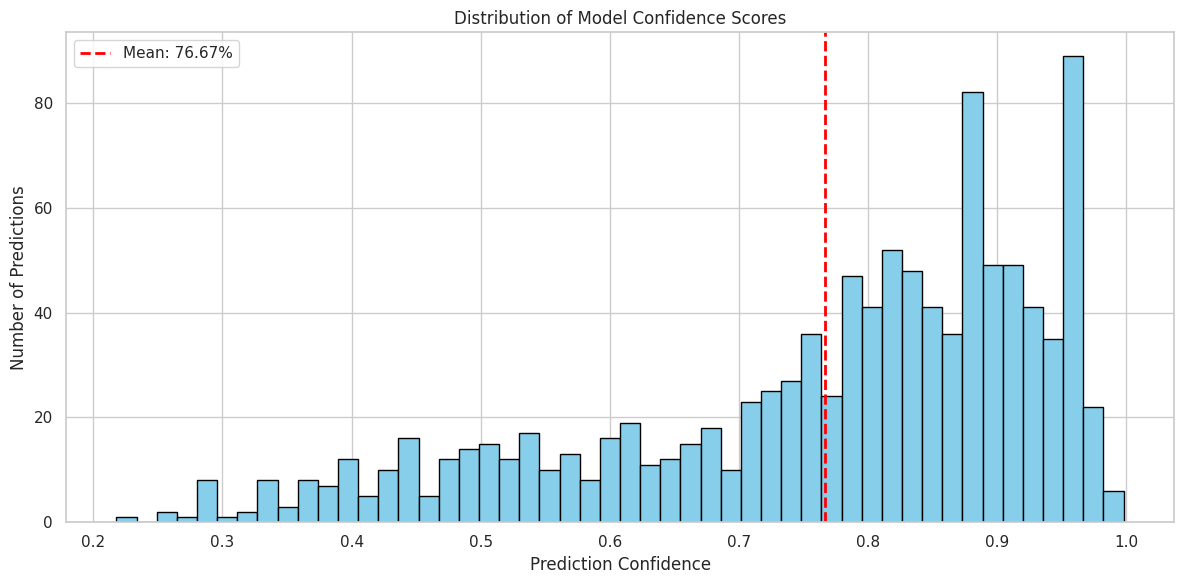

Average prediction confidence: 76.67%
Predictions with >90% confidence: 254 (23.9%)


In [44]:
sample_predictions = role_classifier.predict_proba(X_test_tfidf)
max_confidences = sample_predictions.max(axis=1)

plt.figure(figsize=(12, 6))
plt.hist(max_confidences, bins=50, edgecolor='black', color='skyblue')
plt.xlabel('Prediction Confidence')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Model Confidence Scores')
plt.axvline(x=max_confidences.mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {max_confidences.mean():.2%}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average prediction confidence: {max_confidences.mean():.2%}")
print(f"Predictions with >90% confidence: {(max_confidences > 0.9).sum()} ({(max_confidences > 0.9).sum()/len(max_confidences)*100:.1f}%)")